<a href="https://colab.research.google.com/github/umiSirya/Weather_Prediction_capstone_project/blob/main/ARIMA_%26_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **UV Index Prediction for Italy with ARIMA and SARIMA Models**  

The data used for this analysis was sourced from the **World Ozone and Ultraviolet Radiation Data Centre (WOUDC)**: [https://woudc.org/data/explore.php?lang=en](https://woudc.org/data/explore.php?lang=en). The dataset specifically focuses on **UV index measurements in Italy**. The goal is to predict the **daily maximum UV index** using **ARIMA** and **SARIMA** models to capture both short-term dependencies and potential seasonality.  


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
import sklearn

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [3]:
df=pd.read_csv('/content/result.csv')
df.head()

,Y,X,uv_index_hourly_average,url,dataset,instance_datetime,platform_id,platform_name,country,gaw_id,instrument_name,instrument_model,instrument_number,uv_index_qa,instance_hour,platform_type,data_payload_id,latest_observation,uv_index_daily_max,agency
0,45.74,7.36,0.177875,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,9,STN,2884025,0,1.19455,ARPA-VDA
1,45.74,7.36,1.194550,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,13,STN,2884039,0,1.19455,ARPA-VDA
2,45.74,7.36,0.188125,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,16,STN,2884049,0,1.19455,ARPA-VDA
3,45.74,7.36,0.989250,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/31 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,11,STN,2884032,0,1.19455,ARPA-VDA
4,45.74,7.36,0.544150,http://woudc.org/archive/Archive-NewFormat/Spe...,Spectral,2017/10/30 00:00:00,479,Aosta,ITA,AST,brewer,MKIV,66,P,15,STN,2880762,0,1.49725,ARPA-VDA


# **Exploratory Data Analysis**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6940 entries, 0 to 6939
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Y                        6940 non-null   float64
 1   X                        6940 non-null   float64
 2   uv_index_hourly_average  6940 non-null   float64
 3   url                      6940 non-null   object 
 4   dataset                  6940 non-null   object 
 5   instance_datetime        6940 non-null   object 
 6   platform_id              6940 non-null   int64  
 7   platform_name            6940 non-null   object 
 8   country                  6940 non-null   object 
 9   gaw_id                   6940 non-null   object 
 10  instrument_name          6940 non-null   object 
 11  instrument_model         6940 non-null   object 
 12  instrument_number        6940 non-null   int64  
 13  uv_index_qa              6940 non-null   object 
 14  instance_hour           

In [5]:
# changing dtype of instance_datetime to datetime
df['instance_datetime'] = pd.to_datetime(df['instance_datetime'])

In [6]:
# extracting the date only from instance_datetime
df['instance_date'] = df['instance_datetime'].dt.date

In [7]:
df = df[['instance_datetime', 'uv_index_daily_max']]

In [8]:
# Set datetime as index
df.set_index('instance_datetime', inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6940 entries, 2017-10-31 to 2009-12-31
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   uv_index_daily_max  6940 non-null   float64
dtypes: float64(1)
memory usage: 108.4 KB


In [10]:
df

,uv_index_daily_max
instance_datetime,
2017-10-31,1.194550
2017-10-31,1.194550
2017-10-31,1.194550
2017-10-31,1.194550
2017-10-30,1.497250
...,...
2009-12-31,0.427563
2009-12-31,0.427563
2009-12-31,0.427563


In [11]:
#checking for null values
df.isnull().sum()

,0
uv_index_daily_max,0


<ipython-input-12-597bd890e5d9>:23: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127774 (\N{SUN WITH FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


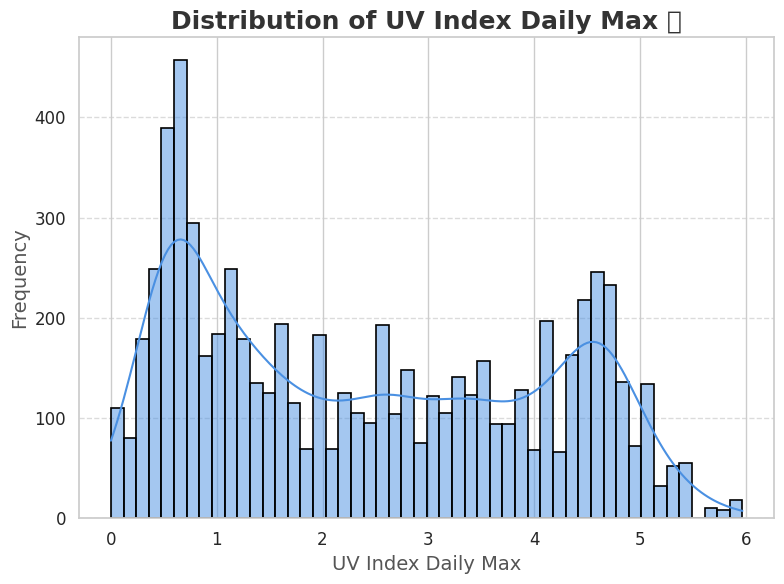

In [12]:
#Frequency Distribution of UV Index daily max

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))

sns.histplot(
    data=df,
    x='uv_index_daily_max',
    bins=50,
    kde=True,
    color="#4A90E2",
    edgecolor="black",
    linewidth=1.2
)


plt.title('Distribution of UV Index Daily Max 🌞', fontsize=18, fontweight='bold', color="#333333")
plt.xlabel('UV Index Daily Max', fontsize=14, color="#555555")
plt.ylabel('Frequency', fontsize=14, color="#555555")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# **Data Pre-Processing**

# 1. Visualuzing The Data

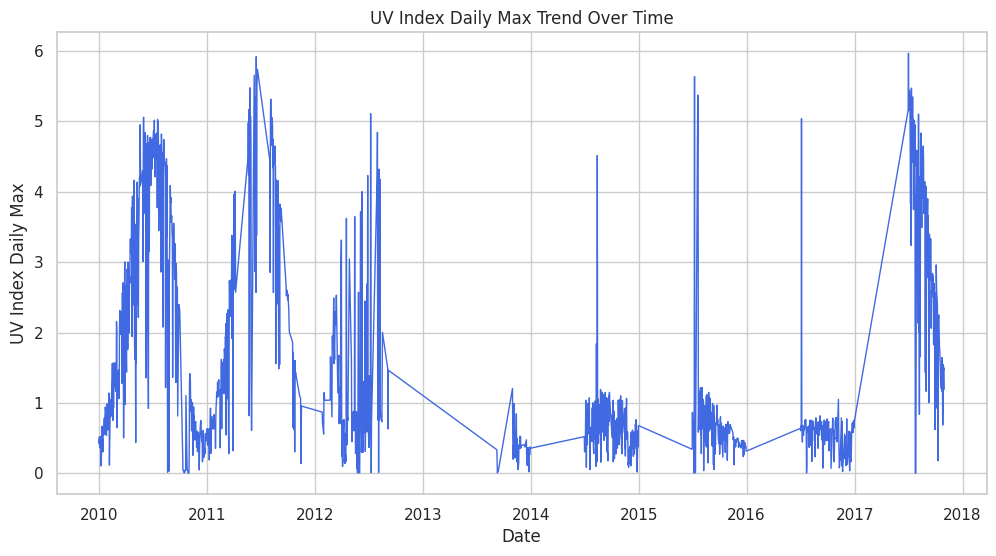

In [13]:
# Plotting the original UV Index trend over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['uv_index_daily_max'], color='royalblue', linewidth=1)
plt.title('UV Index Daily Max Trend Over Time')
plt.xlabel('Date')
plt.ylabel('UV Index Daily Max')
plt.grid(True)
plt.show()

# 2. Checking for Stationarity

# 3. ADF Test and Decomposition for Stationarity Analysis

Original Data Stationarity Check:
ADF Statistic: -3.54
p-value: 0.007
✅ Data is stationary!


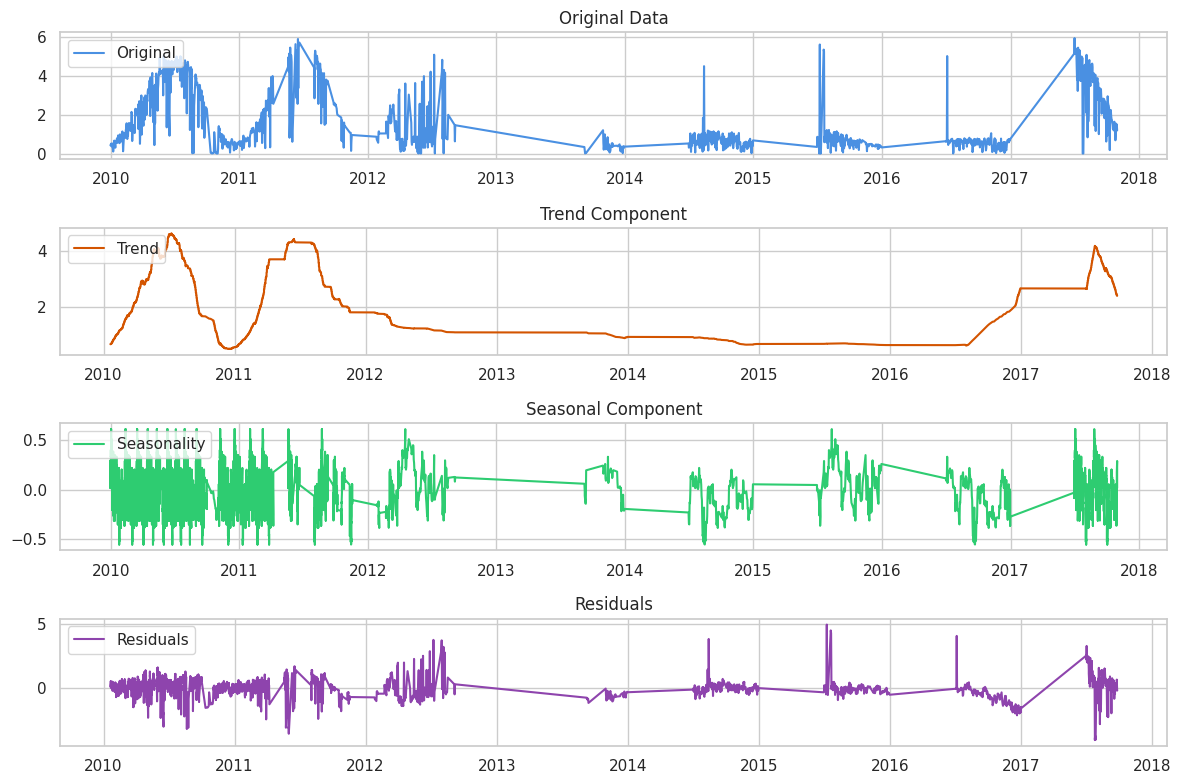

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

# ADF Test function
def adf_test(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.2f}')
    print(f'p-value: {result[1]:.3f}')
    if result[1] <= 0.05:
        print("✅ Data is stationary!")
    else:
        print("❌ Data is still non-stationary.")

# Check stationarity on the original data
print("Original Data Stationarity Check:")
adf_test(df['uv_index_daily_max'])

# Seasonal decomposition on original data
try:
    decomposition = seasonal_decompose(df['uv_index_daily_max'], model='additive', period=365)

    # Plot decomposition results
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(df['uv_index_daily_max'], label='Original', color='#4A90E2')
    plt.legend(loc='upper left')
    plt.title('Original Data')

    plt.subplot(4, 1, 2)
    plt.plot(decomposition.trend, label='Trend', color='#D35400')
    plt.legend(loc='upper left')
    plt.title('Trend Component')

    plt.subplot(4, 1, 3)
    plt.plot(decomposition.seasonal, label='Seasonality', color='#2ECC71')
    plt.legend(loc='upper left')
    plt.title('Seasonal Component')

    plt.subplot(4, 1, 4)
    plt.plot(decomposition.resid, label='Residuals', color='#8E44AD')
    plt.legend(loc='upper left')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"⚠️ Decomposition failed: {e}")


# Plot ACF & PACF

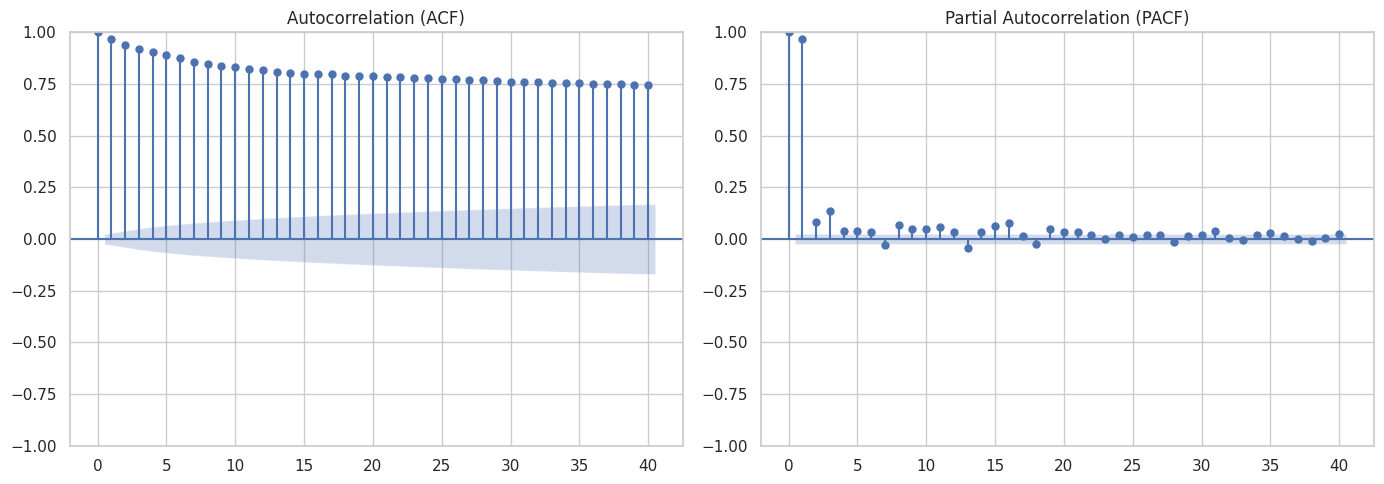

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['uv_index_daily_max'].dropna(), ax=ax[0], lags=40)
plot_pacf(df['uv_index_daily_max'].dropna(), ax=ax[1], lags=40)
ax[0].set_title('Autocorrelation (ACF)')
ax[1].set_title('Partial Autocorrelation (PACF)')
plt.tight_layout()
plt.show()

# Train and Test Split

In [16]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


# ARIMA Model Training

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]:.2f}")
    print(f"p-value: {result[1]:.2f}")
    print("Stationary" if result[1] < 0.05 else "Not Stationary")

# Test original data
adf_test(df['uv_index_daily_max'])



ADF Statistic: -3.54
p-value: 0.01
Stationary


In [18]:
arima_model = ARIMA(train['uv_index_daily_max'], order=(1, 0, 1))
arima_result = arima_model.fit()

print(arima_result.summary())

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsm

                               SARIMAX Results                                
Dep. Variable:     uv_index_daily_max   No. Observations:                 5552
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3467.143
Date:                Mon, 17 Mar 2025   AIC                           6942.287
Time:                        10:36:31   BIC                           6968.774
Sample:                             0   HQIC                          6951.521
                               - 5552                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5713      0.193     13.353      0.000       2.194       2.949
ar.L1          0.9725      0.005    178.959      0.000       0.962       0.983
ma.L1         -0.1313      0.007    -19.819      0.0

# Key Takeaways


### **Model Coefficients**  

- **AR(1) coefficient (0.9725):** Strong positive influence of the previous day's UV index on today’s value (**P>|z| = 0.000**, statistically significant). This suggests the UV index is highly persistent.  
- **MA(1) coefficient (-0.1313):** Small but significant negative influence of the previous day's error on today's value (**P>|z| = 0.000**). This indicates the model corrects for minor over-predictions.  
- **sigma² (0.2040):** Residual variance is relatively low, showing the model captures most of the data’s variability.  


### **Diagnostic Tests**  

- **Ljung-Box Test (Q-statistic):** 1.79 (**Prob = 0.18**) → No significant autocorrelation in residuals — a good sign.  
- **Jarque-Bera (JB) Test:** 460,730.98 (**Prob = 0.00**) → Residuals are not normally distributed — common in real-world weather data.  
- **Heteroskedasticity Test (H):** 0.22 (**Prob = 0.00**) → Significant heteroskedasticity — variance isn’t stable, which may need further investigation.  
- **Skewness (-0.18):** Slight negative skew — not severe enough to impact performance but worth noting.  
- **Kurtosis (47.63):** Extremely high kurtosis suggests heavy tails and potential outliers — likely driven by extreme UV spikes.  


### **Summary of Key Takeaways**  

- The **AR(1)** coefficient is strong and statistically significant, meaning the model captures short-term patterns in UV index well.  
- **No autocorrelation** in residuals (Ljung-Box test) — a sign the model fits the data properly.  
- Residuals **are not normally distributed**, and **heteroskedasticity** is present — this could affect confidence intervals.  
- **High kurtosis** suggests extreme values (outliers) exist and may need handling if they occur frequently.  


### **Next Steps (Recommendations)**  

- **For short-term forecasts:** The model looks reliable despite non-normal residuals — it should give accurate next-day UV index predictions.  
- **For long-term stability:** Consider trying a **SARIMA** model to handle seasonality or **ARCH/GARCH** to account for changing variance.  
- **For outlier handling:** Experiment with **log transformations** or **Box-Cox** to reduce the impact of extreme values.  



# Forecast on Test Data

Actual: 3.53, Predicted: 3.50
Actual: 3.53, Predicted: 3.48
Actual: 3.53, Predicted: 3.45
Actual: 0.44, Predicted: 3.43
Actual: 0.44, Predicted: 3.40


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


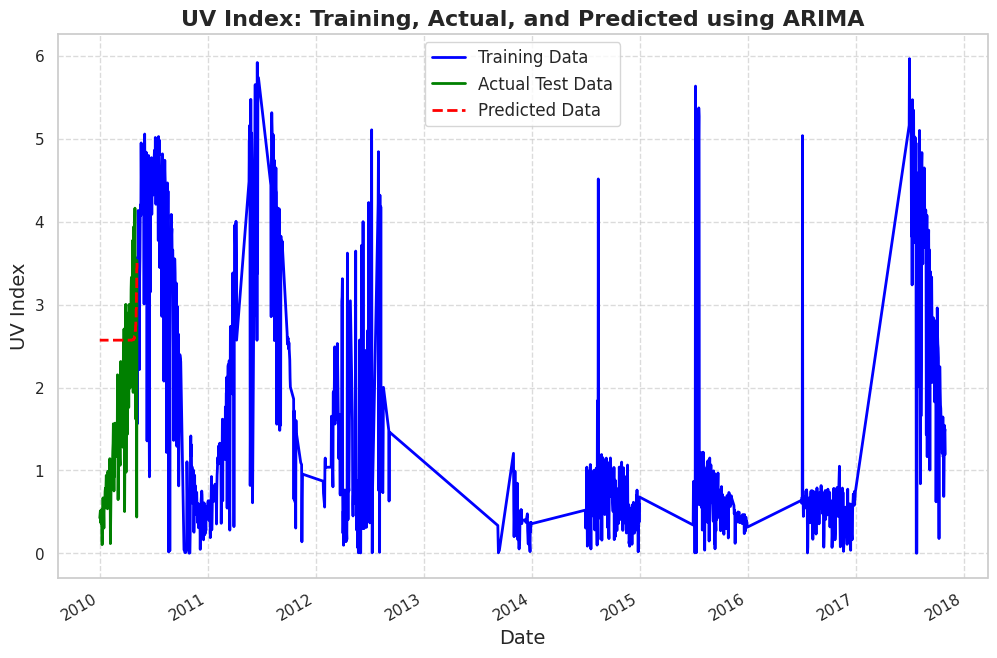

In [19]:
start = len(train)
end = len(train) + len(test) - 1

forecast = arima_result.predict(start=start, end=end, typ='levels')

# Ensure both actual and predicted values are flattened NumPy arrays
actual_values = test.values.flatten()
predicted_values = np.array(forecast).flatten()

# Print actual vs predicted values side by side
for actual, predicted in zip(actual_values[:5], predicted_values[:5]):
    print(f"Actual: {actual:.2f}, Predicted: {predicted:.2f}")

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train.iloc[:, 0], label='Training Data', color='blue', linewidth=2)
plt.plot(test.index, test.iloc[:, 0], label='Actual Test Data', color='green', linewidth=2)
plt.plot(test.index, predicted_values, label='Predicted Data', color='red', linestyle='--', linewidth=2)

plt.title("UV Index: Training, Actual, and Predicted using ARIMA", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("UV Index", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.gcf().autofmt_xdate()

plt.show()




# Evaluate the Model

In [20]:
test_single = test.iloc[:, 0]

mae = mean_absolute_error(test_single, predicted_values)
mse = mean_squared_error(test_single, predicted_values)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 1.16
Mean Squared Error (MSE): 1.78
Root Mean Squared Error (RMSE): 1.34


# **SARIMA Model Training**
**SARIMA=ARIMA Model+Seasonal AR Terms+Seasonal MA Terms+Seasonal Differencing**

Extends ARIMA by adding seasonal components: Seasonal AR and MA terms capture patterns that repeat over a fixed period (e.g., monthly, yearly).

Seasonal differencing removes repeating seasonal trends.

In [21]:
sarima_model = SARIMAX(
    train['uv_index_daily_max'],
    order=(1, 0, 1),
    seasonal_order=(1, 0, 1, 12)
)

sarima_result = sarima_model.fit()
print(sarima_result.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 uv_index_daily_max   No. Observations:                 5552
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood               -3477.229
Date:                            Mon, 17 Mar 2025   AIC                           6964.458
Time:                                    10:36:56   BIC                           6997.568
Sample:                                         0   HQIC                          6976.001
                                           - 5552                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9907      0.002    475.198      0.000       0.987       0.995
ma.L1         -0.1409      0.007   

# Plot Forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


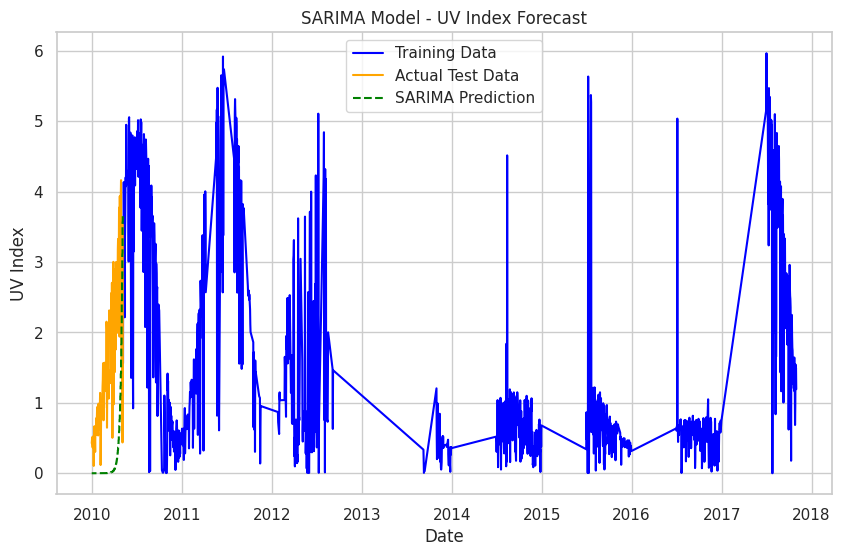

In [22]:
sarima_forecast = sarima_result.predict(start=len(train), end=len(train) + len(test) - 1)

plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data', color='blue')
plt.plot(test.index, test, label='Actual Test Data', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Prediction', color='green', linestyle='--')

plt.legend()
plt.title("SARIMA Model - UV Index Forecast")
plt.xlabel("Date")
plt.ylabel("UV Index")
plt.grid(True)
plt.show()


# Evaluate the model

In [23]:
mae_sarima = mean_absolute_error(test, sarima_forecast)
mse_sarima = mean_squared_error(test, sarima_forecast)
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA Mean Absolute Error (MAE): {mae_sarima:.2f}")
print(f"SARIMA Mean Squared Error (MSE): {mse_sarima:.2f}")
print(f"SARIMA Root Mean Squared Error (RMSE): {rmse_sarima:.2f}")


SARIMA Mean Absolute Error (MAE): 1.53
SARIMA Mean Squared Error (MSE): 3.08
SARIMA Root Mean Squared Error (RMSE): 1.76
